# Etap 1

Celem notatnika jest przegląd kilku dostępnych architektur konwolucyjnych sieci neuronowych i przetestowanie ich zastosowania do rozpoznawania elementów konstrukcyjnych. Sprawdzano również zastosowanie transferu wiedzy z modeli wytrenowanych na zbiorze danych ImageNet. Zbiór ten składa się z milionów obrazów ręcznie zaklasyfikowanych do co najmniej 20 tysięcy klas.

Wybrane architektury:
- ResNet50 - rozmiar wejściowy 224x224
- Xception - rozmiar wejściowy 299x299
- VGG16 - rozmiar wejściowy 224x224

Biblioteka Keras udostępnia modele dla każdej wyżej wymienionej architektury oraz gotowe wagi z możliwością ich zamrożenia podczas treningu na własnych danych.

#### Zbiór danych wykorzystany w testach
Na podstawie dostarczonych plików .stl wygenerowano 1520 obrazów o rozdzielczości 300x300 pikseli. Dla każdego pliku .stl wygenerowano 4 obrazy pod różnym kątem. 
Ograniczono się do czterech klas elementów:
- ceownik - 308 plików
- dwuteownik - 324 plików
- katownik - 92 plików
- plaskownik - 796 plików

Całą pulę podzielono na zbiór treningowy i testowy w stosunku 80:20 dla każdej klasy.

#### Przebieg testów
Dla każdej architektury wytrenowano model trzykrotnie:
- Model zainicjowany wytrenowanymi wagi z zablokowaną możliwością edycji
- Model zainicjowany wytrenowanymi wagi z możliwością edycji
- Model zainicjowany losowymi wagami
 
Do gotowych modeli dodano dwie warstwy zwracające prawdopodobieństwo przynależności do każdej z klas. Każdy model uruchomiono z wykorzystaniem identycznych hiperparametrów. W celu porównania skuteczności wygenerowano macierze pomyłek oraz obliczono miary trafności.

# Import zależności

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow.keras.applications.resnet50 as resnet50
import tensorflow.keras.applications.xception as xception
import tensorflow.keras.applications.vgg16 as vgg16
ROWS=300
COLS=300

# Definicje funkcji

In [2]:
def preprocess_and_load_data(preprocessing_function, batch_size = 16):
    resnet50_idg = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_gen = resnet50_idg.flow_from_directory(
        'STL_IMAGES/train',
        target_size=(ROWS, COLS),
        batch_size = batch_size
    )

    test_gen = resnet50_idg.flow_from_directory(
        'STL_IMAGES/test',
        target_size=(ROWS, COLS),
        batch_size = batch_size,
        shuffle = False,
        class_mode='binary'
    )
    return train_gen, test_gen

def prepare_model(pretrained_model):
    nclass = len(train_gen.class_indices)
    resnet_model = Sequential()
    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dense(128, activation='relu'))
    resnet_model.add(Dense(nclass, activation='softmax'))

    model = resnet_model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(learning_rate=0.005),
                  metrics=['accuracy'])
    model.summary()
    return model

def fit_model(model, weights_path):
    checkpoint = ModelCheckpoint(weights_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="accuracy", mode="max", patience=10)
    callbacks_list = [checkpoint, early]
    history = model.fit(train_gen, 
                        epochs=10,
                        shuffle=True, 
                        verbose=2,
                        callbacks=callbacks_list)
    return history

def show_history_plot(history):
    sns.set(font_scale = 1)
    fig1 = plt.gcf()
    plt.plot(history.history['accuracy'])
    plt.grid()
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['accuracy'])
    plt.show()
    
def predict(model, test_gen, weights_path):
    model.load_weights(weights_path)
    predicts = model.predict(test_gen, verbose = True, workers = 2)
    return predicts

def show_confusion_matrix(train_gen, test_gen, predicts):
    sns.set(font_scale = 2)
    label_names = list(train_gen.class_indices)
    y_true = test_gen.labels
    y_pred = np.argmax(predicts, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (15, 15))

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(label_names)
    ax.yaxis.set_ticklabels(label_names)

    print("Accaccuracy score: ", accuracy_score(y_true, y_pred)*100)
    
def show_misclassified():
    predicts_top1 = np.argmax(predicts, axis=1)
    label_index = {v: k for k,v in train_gen.class_indices.items()}
    predicts_top1 = [label_index[p] for p in predicts_top1]

    df = pd.DataFrame(columns=['fname', 'true_label', 'predicted_label'])
    df['fname'] = [os.path.basename(x) for x in test_gen.filenames]
    df['true_label'] = [label_index[p] for p in test_gen.labels]
    df['predicted_label'] = predicts_top1

    return df.iloc[np.where((df['true_label'] != df['predicted_label']))]

# Prównanie istniejących rozwiązań
## ResNet50 - transfer wiedzy - zamrożone wagi

In [3]:
train_gen, test_gen = preprocess_and_load_data(resnet50.preprocess_input)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.


In [4]:
pretrained_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = False
model = prepare_model(pretrained_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 49,802,756
Trainable params: 26,215,044
Non-trainable params: 23,587,712
_________________________________________________________________


In [5]:
weights_path = "resnet50_weights_with_freeze.best.hdf5"
history = fit_model(model, weights_path)

Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.49507, saving model to resnet50_weights_with_freeze.best.hdf5
77/77 - 10s - loss: 9.2473 - accuracy: 0.4951 - 10s/epoch - 126ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.49507 to 0.70033, saving model to resnet50_weights_with_freeze.best.hdf5
77/77 - 6s - loss: 0.8530 - accuracy: 0.7003 - 6s/epoch - 74ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.70033 to 0.72496, saving model to resnet50_weights_with_freeze.best.hdf5
77/77 - 6s - loss: 0.7616 - accuracy: 0.7250 - 6s/epoch - 72ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.72496 to 0.73481, saving model to resnet50_weights_with_freeze.best.hdf5
77/77 - 6s - loss: 0.7284 - accuracy: 0.7348 - 6s/epoch - 72ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.73481 to 0.73892, saving model to resnet50_weights_with_freeze.best.hdf5
77/77 - 6s - loss: 0.6960 - accuracy: 0.7389 - 6s/epoch - 73ms/step
Epoch 6/10

Epoch 6: accuracy did not improve from 0.73892
77/77 

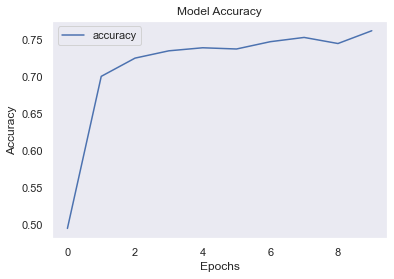

In [6]:
show_history_plot(history)

19/19 [==============================] - 3s 110ms/step
Accaccuracy score:  72.84768211920529


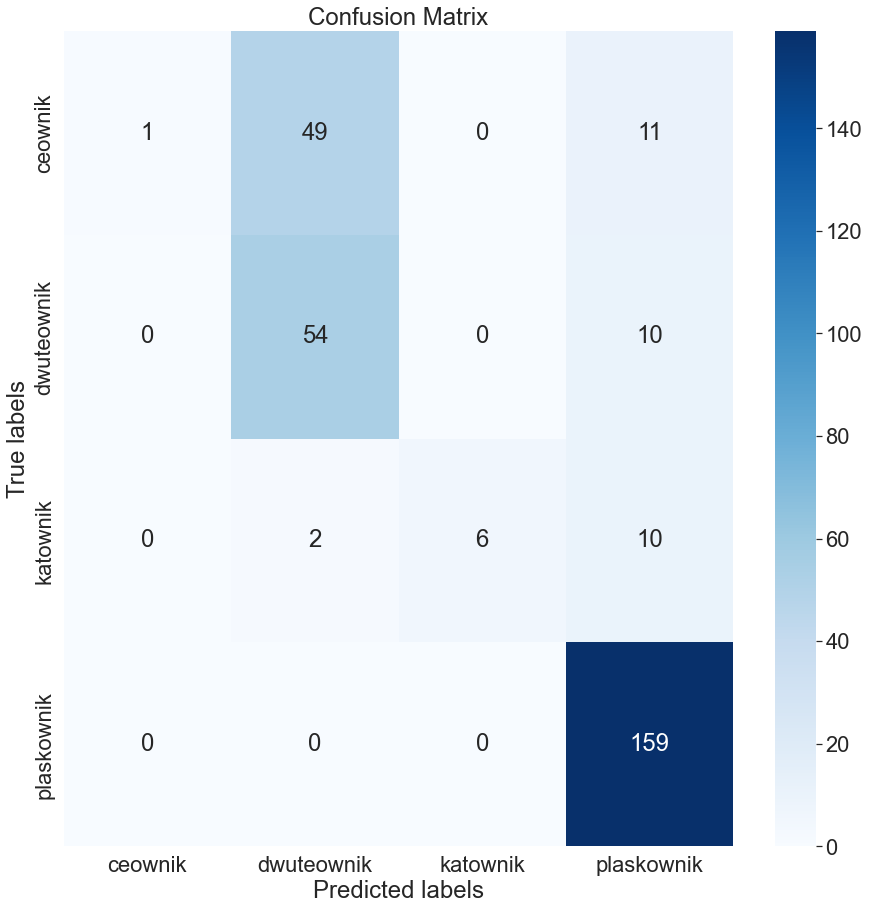

In [7]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [8]:
show_misclassified()

,fname,true_label,predicted_label
0,ceownik_00001-view01.png,ceownik,dwuteownik
1,ceownik_00001-view03.png,ceownik,plaskownik
2,ceownik_00002-view02.png,ceownik,plaskownik
3,ceownik_00003-view02.png,ceownik,plaskownik
4,ceownik_00006-view02.png,ceownik,plaskownik
...,...,...,...
136,katownik_00019-view03.png,katownik,plaskownik
138,katownik_00020-view02.png,katownik,plaskownik
140,katownik_00023-view02.png,katownik,dwuteownik
141,katownik_00023-view03.png,katownik,dwuteownik


## ResNet50 - transfer wiedzy - bez zamrożenia

In [9]:
train_gen, test_gen = preprocess_and_load_data(resnet50.preprocess_input)

pretrained_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = True
model = prepare_model(pretrained_model)

weights_path = "resnet50_weights_without_freeze.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               26214528  
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 49,802,756
Trainable params: 49,749,636
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.61494, saving model to resnet50_

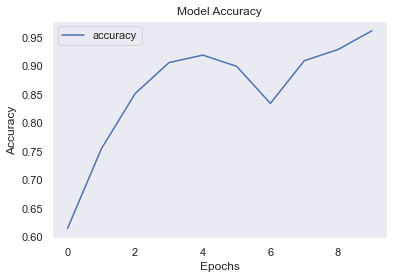

In [10]:
show_history_plot(history)

19/19 [==============================] - 2s 72ms/step
Accaccuracy score:  93.37748344370861


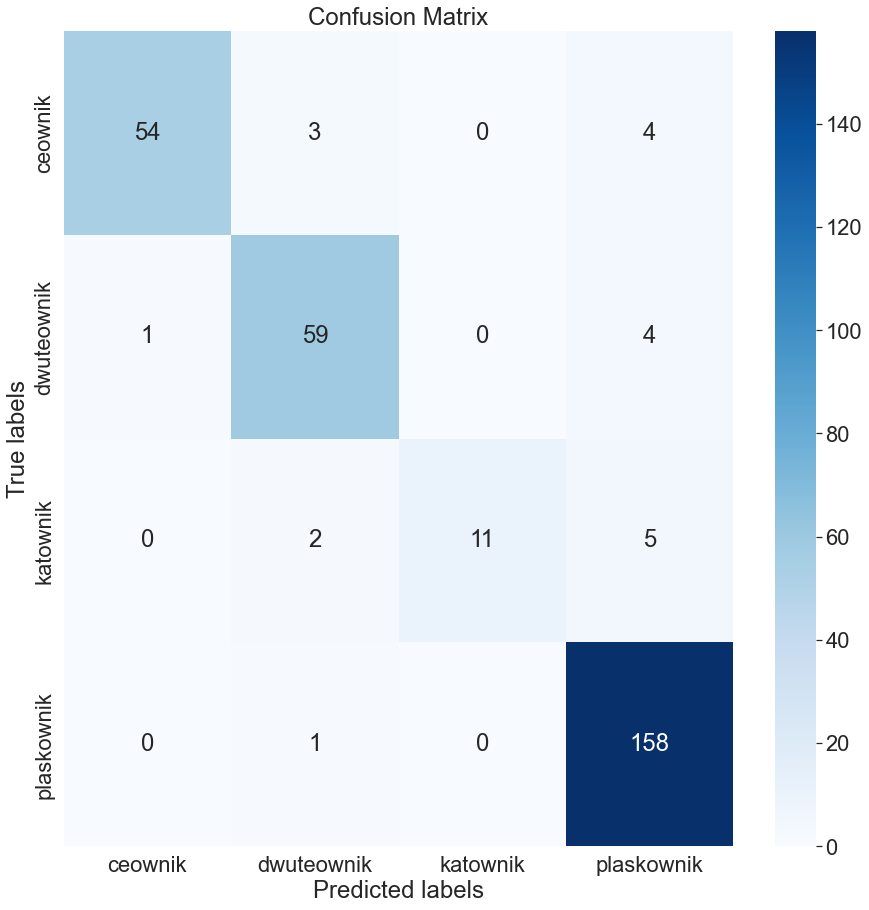

In [11]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [12]:
show_misclassified()

,fname,true_label,predicted_label
2,ceownik_00002-view02.png,ceownik,dwuteownik
3,ceownik_00003-view02.png,ceownik,dwuteownik
4,ceownik_00006-view02.png,ceownik,plaskownik
39,ceownik_00051-view01.png,ceownik,plaskownik
40,ceownik_00051-view02.png,ceownik,plaskownik
42,ceownik_00055-view01.png,ceownik,dwuteownik
46,ceownik_00063-view03.png,ceownik,plaskownik
78,dwuteownik_00023-view01.png,dwuteownik,plaskownik
81,dwuteownik_00027-view04.png,dwuteownik,plaskownik
92,dwuteownik_00042-view03.png,dwuteownik,plaskownik


## ResNet50 - bez transferu wiedzy

In [13]:
train_gen, test_gen = preprocess_and_load_data(resnet50.preprocess_input)

pretrained_model = resnet50.ResNet50(weights=None, include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = True
model = prepare_model(pretrained_model)

weights_path = "resnet50_weights.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 204800)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               26214528  
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 49,802,756
Trainable params: 49,749,636
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.50821, saving model to resnet50_

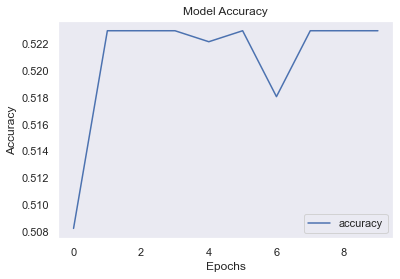

In [14]:
show_history_plot(history)

19/19 [==============================] - 2s 72ms/step
Accaccuracy score:  52.64900662251656


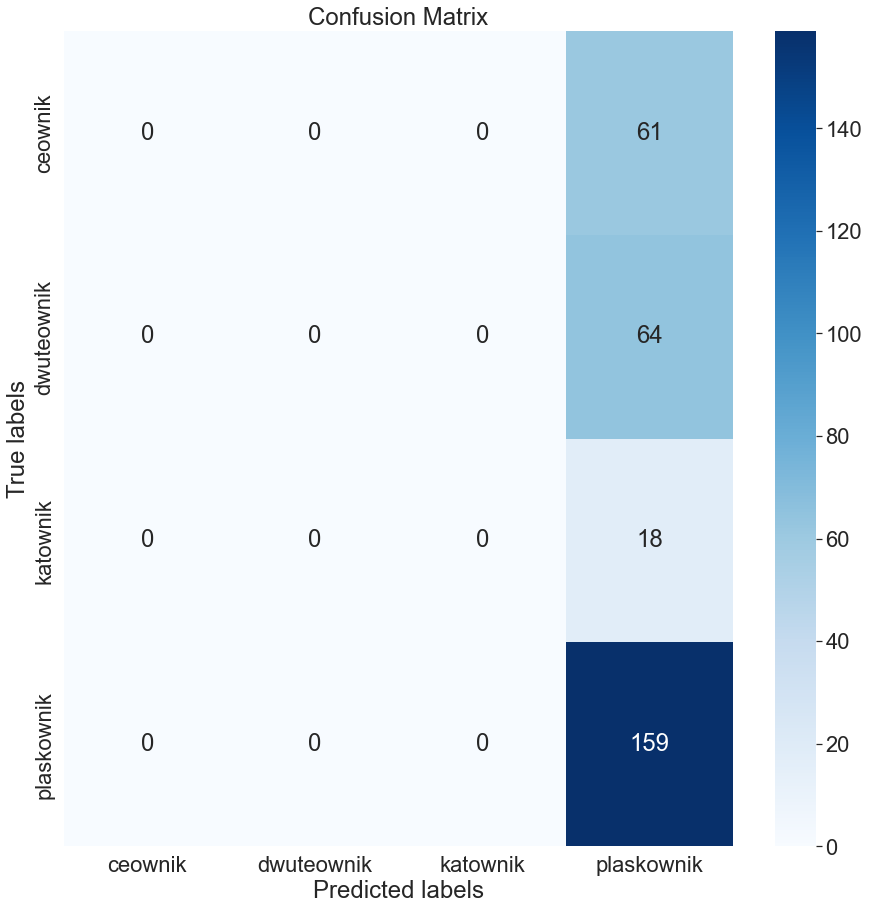

In [15]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [16]:
show_misclassified()

,fname,true_label,predicted_label
0,ceownik_00001-view01.png,ceownik,plaskownik
1,ceownik_00001-view03.png,ceownik,plaskownik
2,ceownik_00002-view02.png,ceownik,plaskownik
3,ceownik_00003-view02.png,ceownik,plaskownik
4,ceownik_00006-view02.png,ceownik,plaskownik
...,...,...,...
138,katownik_00020-view02.png,katownik,plaskownik
139,katownik_00022-view03.png,katownik,plaskownik
140,katownik_00023-view02.png,katownik,plaskownik
141,katownik_00023-view03.png,katownik,plaskownik


## Xception - transfer wiedzy - zamrożone wagi

In [17]:
train_gen, test_gen = preprocess_and_load_data(xception.preprocess_input)

pretrained_model = xception.Xception(weights="imagenet", include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = False
model = prepare_model(pretrained_model)

weights_path = "xception_weights_with_freeze.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_3 (Flatten)         (None, 204800)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               26214528  
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 47,076,524
Trainable params: 26,215,044
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.72414, saving model to xcept

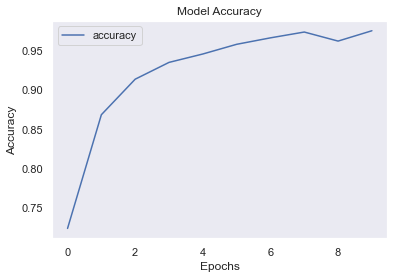

In [18]:
show_history_plot(history)

19/19 [==============================] - 2s 111ms/step
Accaccuracy score:  93.70860927152319


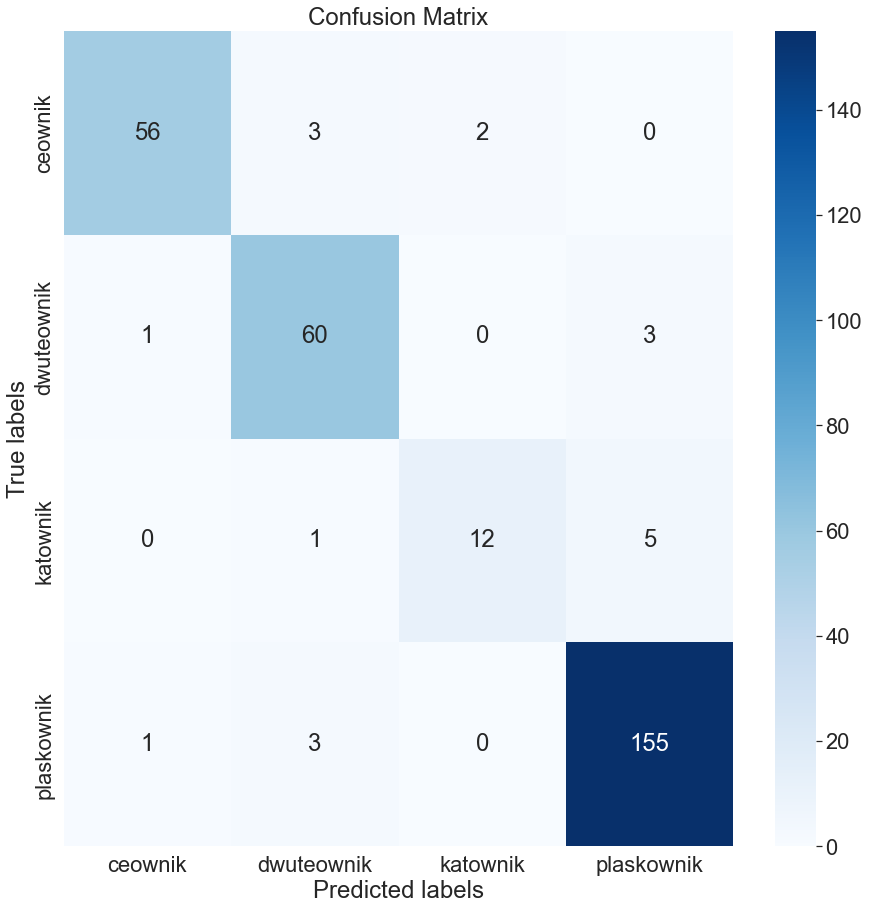

In [19]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [20]:
show_misclassified()

,fname,true_label,predicted_label
0,ceownik_00001-view01.png,ceownik,katownik
3,ceownik_00003-view02.png,ceownik,dwuteownik
12,ceownik_00017-view04.png,ceownik,dwuteownik
58,ceownik_00072-view02.png,ceownik,dwuteownik
60,ceownik_00076-view01.png,ceownik,katownik
79,dwuteownik_00024-view02.png,dwuteownik,plaskownik
92,dwuteownik_00042-view03.png,dwuteownik,plaskownik
111,dwuteownik_00069-view02.png,dwuteownik,ceownik
122,dwuteownik_00082-view04.png,dwuteownik,plaskownik
125,katownik_00003-view04.png,katownik,plaskownik


## Xception - transfer wiedzy - bez zamrożenia

In [21]:
train_gen, test_gen = preprocess_and_load_data(xception.preprocess_input)

pretrained_model = xception.Xception(weights="imagenet", include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = True
model = prepare_model(pretrained_model)

weights_path = "xception_weights_without_freeze.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_4 (Flatten)         (None, 204800)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               26214528  
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 47,076,524
Trainable params: 47,021,996
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.66502, saving model to xception_

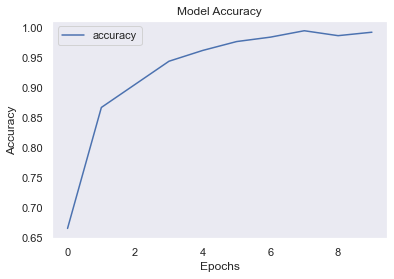

In [22]:
show_history_plot(history)

19/19 [==============================] - 2s 85ms/step
Accaccuracy score:  94.70198675496688


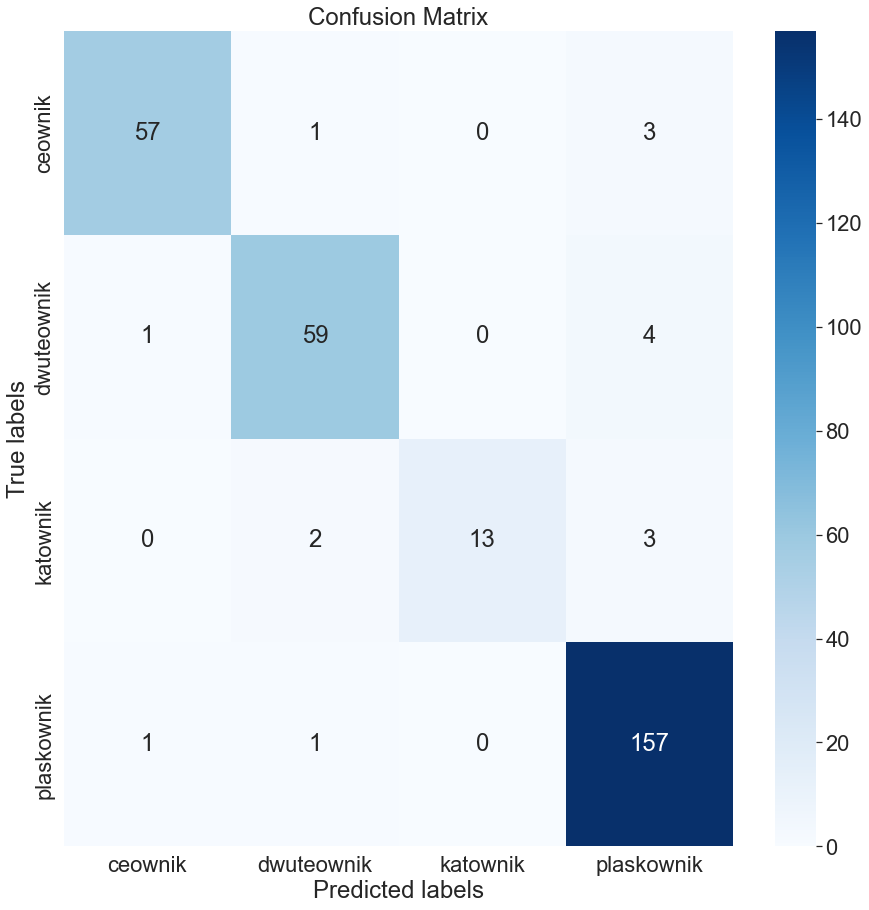

In [23]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [24]:
show_misclassified()

,fname,true_label,predicted_label
2,ceownik_00002-view02.png,ceownik,plaskownik
3,ceownik_00003-view02.png,ceownik,plaskownik
42,ceownik_00055-view01.png,ceownik,plaskownik
46,ceownik_00063-view03.png,ceownik,dwuteownik
79,dwuteownik_00024-view02.png,dwuteownik,plaskownik
81,dwuteownik_00027-view04.png,dwuteownik,plaskownik
96,dwuteownik_00046-view01.png,dwuteownik,plaskownik
117,dwuteownik_00077-view01.png,dwuteownik,ceownik
122,dwuteownik_00082-view04.png,dwuteownik,plaskownik
130,katownik_00012-view03.png,katownik,plaskownik


## Xception - bez transferu wiedzy

In [25]:
train_gen, test_gen = preprocess_and_load_data(xception.preprocess_input)

pretrained_model = xception.Xception(weights=None, include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = True
model = prepare_model(pretrained_model)

weights_path = "xception_weights.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_5 (Flatten)         (None, 204800)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               26214528  
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 47,076,524
Trainable params: 47,021,996
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.55747, saving model to xception_

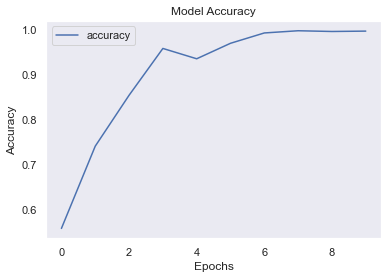

In [26]:
show_history_plot(history)

19/19 [==============================] - 2s 88ms/step
Accaccuracy score:  52.64900662251656


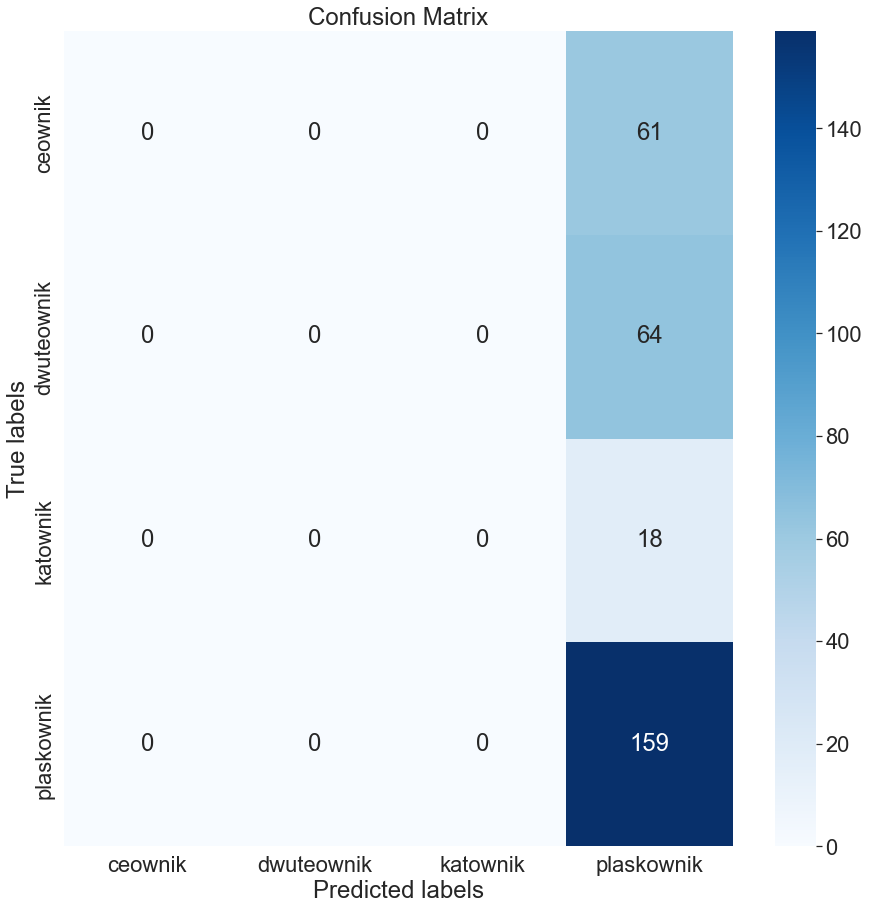

In [27]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [28]:
show_misclassified()

,fname,true_label,predicted_label
0,ceownik_00001-view01.png,ceownik,plaskownik
1,ceownik_00001-view03.png,ceownik,plaskownik
2,ceownik_00002-view02.png,ceownik,plaskownik
3,ceownik_00003-view02.png,ceownik,plaskownik
4,ceownik_00006-view02.png,ceownik,plaskownik
...,...,...,...
138,katownik_00020-view02.png,katownik,plaskownik
139,katownik_00022-view03.png,katownik,plaskownik
140,katownik_00023-view02.png,katownik,plaskownik
141,katownik_00023-view03.png,katownik,plaskownik


## VGG16 - transfer wiedzy - zamrożone wagi

In [29]:
train_gen, test_gen = preprocess_and_load_data(vgg16.preprocess_input)

pretrained_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = False
model = prepare_model(pretrained_model)

weights_path = "vgg16_weights_with_freeze.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 41472)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               5308544   
                                                                 
 dense_13 (Dense)            (None, 4)                 516       
                                                                 
Total params: 20,023,748
Trainable params: 5,309,060
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.65107, saving model to vgg16_

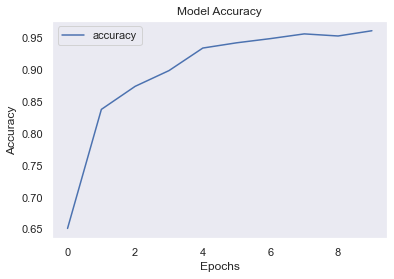

In [30]:
show_history_plot(history)

19/19 [==============================] - 3s 186ms/step
Accaccuracy score:  89.73509933774835


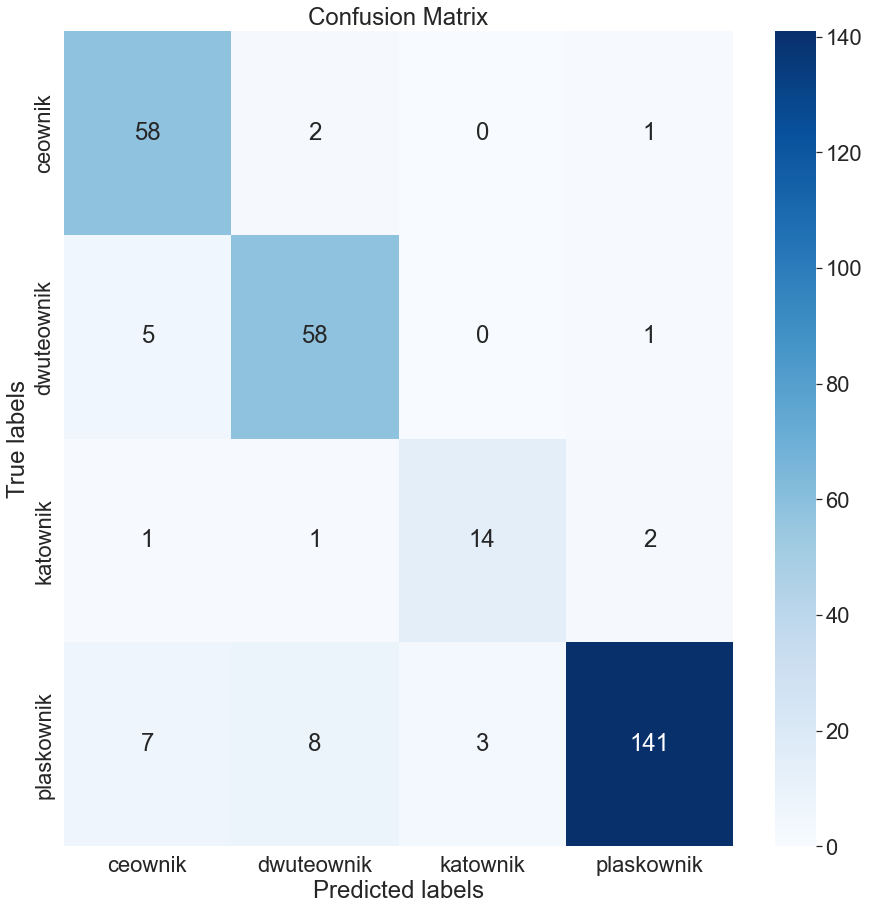

In [31]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [32]:
show_misclassified()

,fname,true_label,predicted_label
2,ceownik_00002-view02.png,ceownik,dwuteownik
3,ceownik_00003-view02.png,ceownik,dwuteownik
42,ceownik_00055-view01.png,ceownik,plaskownik
61,dwuteownik_00001-view03.png,dwuteownik,ceownik
78,dwuteownik_00023-view01.png,dwuteownik,ceownik
81,dwuteownik_00027-view04.png,dwuteownik,ceownik
96,dwuteownik_00046-view01.png,dwuteownik,plaskownik
111,dwuteownik_00069-view02.png,dwuteownik,ceownik
123,dwuteownik_00084-view03.png,dwuteownik,ceownik
133,katownik_00015-view03.png,katownik,ceownik


## VGG16 - transfer wiedzy - bez zamrożenia

In [33]:
train_gen, test_gen = preprocess_and_load_data(vgg16.preprocess_input)

pretrained_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = True
model = prepare_model(pretrained_model)

weights_path = "vgg16_weights_without_freeze.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 41472)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               5308544   
                                                                 
 dense_15 (Dense)            (None, 4)                 516       
                                                                 
Total params: 20,023,748
Trainable params: 20,023,748
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.21593, saving model to vgg16_weights_

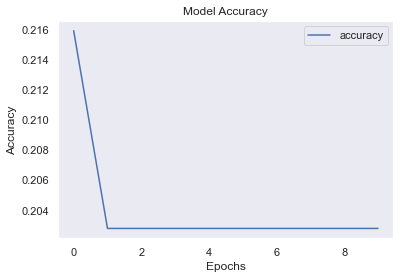

In [34]:
show_history_plot(history)

19/19 [==============================] - 2s 103ms/step
Accaccuracy score:  20.198675496688743


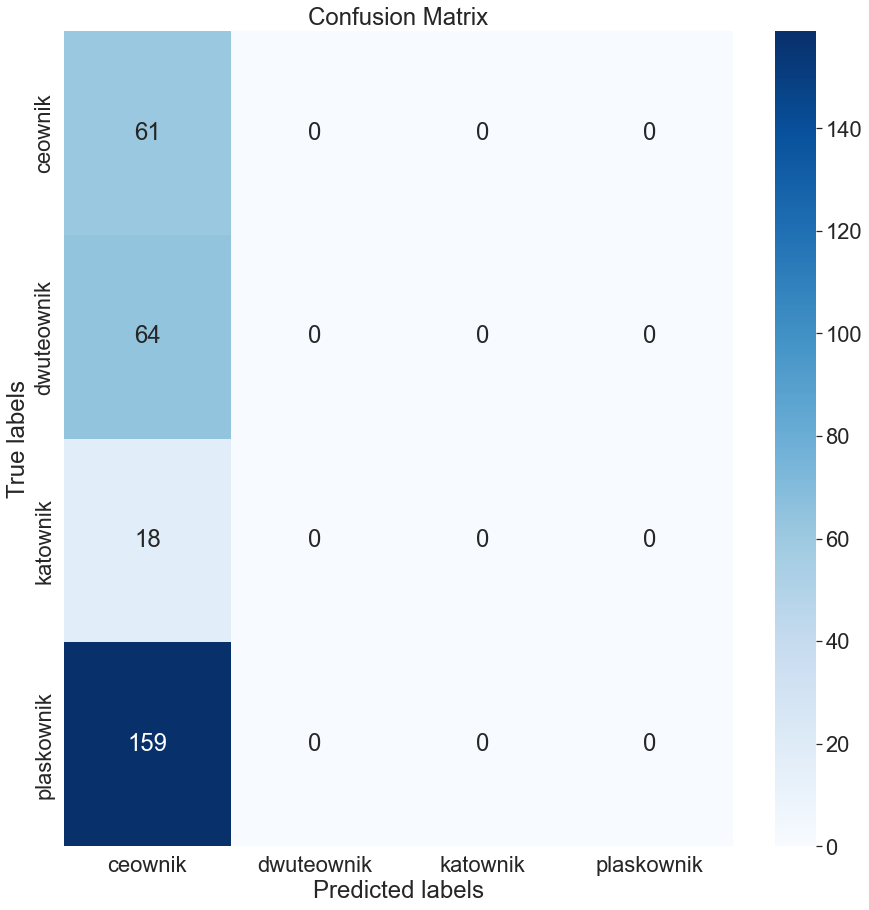

In [35]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [36]:
show_misclassified()

,fname,true_label,predicted_label
61,dwuteownik_00001-view03.png,dwuteownik,ceownik
62,dwuteownik_00002-view01.png,dwuteownik,ceownik
63,dwuteownik_00002-view02.png,dwuteownik,ceownik
64,dwuteownik_00003-view02.png,dwuteownik,ceownik
65,dwuteownik_00005-view01.png,dwuteownik,ceownik
...,...,...,...
297,plaskownik_00193-view03.png,plaskownik,ceownik
298,plaskownik_00194-view01.png,plaskownik,ceownik
299,plaskownik_00197-view04.png,plaskownik,ceownik
300,plaskownik_00199-view02.png,plaskownik,ceownik


## VGG16 - bez transferu wiedzy

In [37]:
train_gen, test_gen = preprocess_and_load_data(vgg16.preprocess_input)

pretrained_model = vgg16.VGG16(weights=None, include_top=False, input_shape=(ROWS, COLS,3))
pretrained_model.trainable = True
model = prepare_model(pretrained_model)

weights_path = "vgg16_weights.best.hdf5"
history = fit_model(model, weights_path)

Found 1218 images belonging to 4 classes.
Found 302 images belonging to 4 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 41472)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               5308544   
                                                                 
 dense_17 (Dense)            (None, 4)                 516       
                                                                 
Total params: 20,023,748
Trainable params: 20,023,748
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.50575, saving model to vgg16_weights.

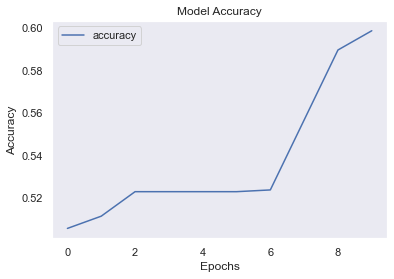

In [38]:
show_history_plot(history)

19/19 [==============================] - 2s 98ms/step
Accaccuracy score:  60.9271523178808


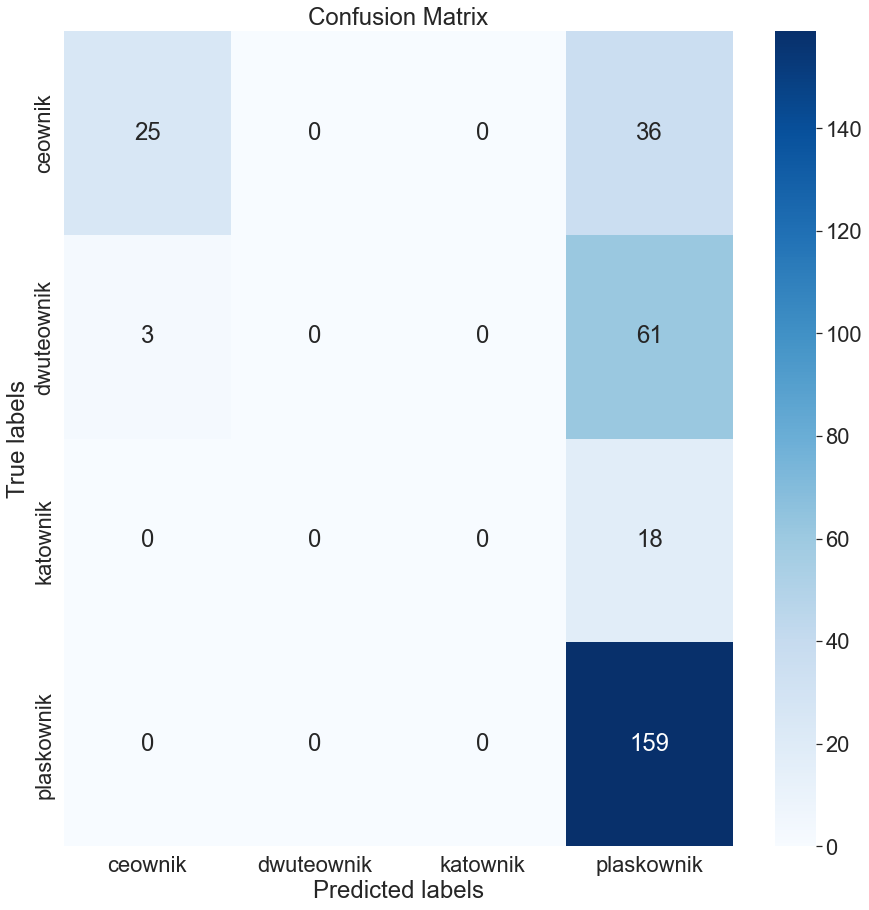

In [39]:
predicts = predict(model, test_gen, weights_path)
show_confusion_matrix(train_gen, test_gen, predicts)

In [40]:
show_misclassified()

,fname,true_label,predicted_label
0,ceownik_00001-view01.png,ceownik,plaskownik
1,ceownik_00001-view03.png,ceownik,plaskownik
2,ceownik_00002-view02.png,ceownik,plaskownik
3,ceownik_00003-view02.png,ceownik,plaskownik
4,ceownik_00006-view02.png,ceownik,plaskownik
...,...,...,...
138,katownik_00020-view02.png,katownik,plaskownik
139,katownik_00022-view03.png,katownik,plaskownik
140,katownik_00023-view02.png,katownik,plaskownik
141,katownik_00023-view03.png,katownik,plaskownik


## Podsumowanie

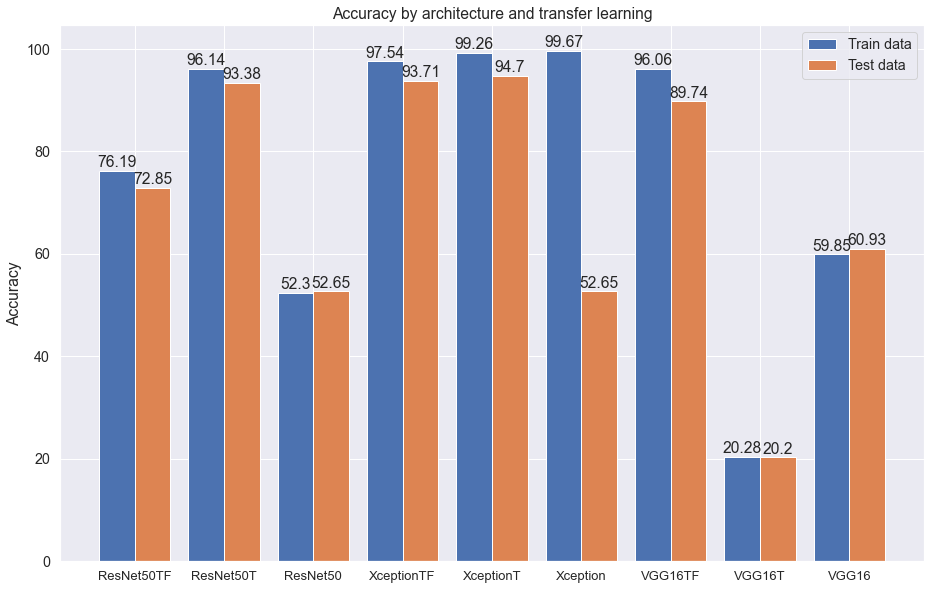

In [109]:
sns.set(font_scale = 1.3)

train_acc = [76.19, 96.14, 52.30, 97.54, 99.26, 99.67, 96.06, 20.28, 59.85]
test_acc = [72.85, 93.38, 52.65, 93.71, 94.70, 52.65, 89.74, 20.20, 60.93]
labels = ['ResNet50TF','ResNet50T','ResNet50', 'XceptionTF', 'XceptionT', 'Xception', 'VGG16TF', 'VGG16T', 'VGG16']

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_acc, width, label='Train data')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test data')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by architecture and transfer learning')
plt.xticks(range(len(labels)), labels, size='small')
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.tight_layout()
fig.set_size_inches(15, 10)

plt.show()

Rozpoczynanie nauki z wagami pozyskanymi ze zbioru ImageNet poprawiało początkowe rezultaty i ułatwia uczenie sieci neuronowej.
Po uczeniu trawjącym 10 epok, modele który miały odblokowaną możliwość aktualizacji zaimportowanych wag uzyskiwały wyższą trafność.

Najlepsze wyniki otrzymano na architektórze Xception.